#**Install and Import Packages**

In [ ]:
!pip install lime
!pip install shap
!pip install dalex
!pip install pdpbox

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from lime import lime_tabular
import lime.lime_tabular
from lime.lime_tabular import LimeTabularExplainer
import shap
import dalex as dx
import scipy.stats as stats
import numpy as np
from pdpbox.pdp import pdp_isolate, pdp_plot


#**Import Data**


Polish companies bankruptcy data Data Set, first year. Retrieved from: https://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data

In [3]:
column_mapping = {
    "Attr1"  : "net profit / total assets",
    "Attr2"  : "total liabilities / total assets",
    "Attr3"  : "working capital / total assets",
    "Attr4"  : "current assets / short-term liabilities",
    "Attr5"  : "[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365",
    "Attr6"  : "retained earnings / total assets",
    "Attr7"  : "EBIT / total assets", 
    "Attr8"  : "book value of equity / total liabilities", 
    "Attr9"  : "sales / total assets", 
    "Attr10" : "equity / total assets", 
    "Attr11" : "(gross profit + extraordinary items + financial expenses) / total assets", 
    "Attr12" : "gross profit / short-term liabilities", 
    "Attr13" : "(gross profit + depreciation) / sales", 
    "Attr14" : "(gross profit + interest) / total assets", 
    "Attr15" : "(total liabilities * 365) / (gross profit + depreciation)", 
    "Attr16" : "(gross profit + depreciation) / total liabilities", 
    "Attr17" : "total assets / total liabilities", 
    "Attr18" : "gross profit / total assets", 
    "Attr19" : "gross profit / sales", 
    "Attr20" : "(inventory * 365) / sales", 
    "Attr21" : "sales (n) / sales (n-1)", 
    "Attr22" : "profit on operating activities / total assets", 
    "Attr23" : "net profit / sales", 
    "Attr24" : "gross profit (in 3 years) / total assets",
    "Attr25" : "(equity - share capital) / total assets",
    "Attr26" : "(net profit + depreciation) / total liabilities",
    "Attr27" : "profit on operating activities / financial expenses", 
    "Attr28" : "working capital / fixed assets", 
    "Attr29" : "logarithm of total assets", 
    "Attr30" : "(total liabilities - cash) / sales", 
    "Attr31" : "(gross profit + interest) / sales", 
    "Attr32" : "(current liabilities * 365) / cost of products sold", 
    "Attr33" : "operating expenses / short-term liabilities", 
    "Attr34" : "operating expenses / total liabilities", 
    "Attr35" : "profit on sales / total assets", 
    "Attr36" : "total sales / total assets", 
    "Attr37" : "(current assets - inventories) / long-term liabilities", 
    "Attr38" : "constant capital / total assets", 
    "Attr39" : "profit on sales / sales", 
    "Attr40" : "(current assets - inventory - receivables) / short-term liabilities", 
    "Attr41" : "total liabilities / ((profit on operating activities + depreciation) * (12/365))", 
    "Attr42" : "profit on operating activities / sales", 
    "Attr43" : "rotation receivables + inventory turnover in days", 
    "Attr44" : "(receivables * 365) / sales", 
    "Attr45" : "net profit / inventory", 
    "Attr46" : "(current assets - inventory) / short-term liabilities", 
    "Attr47" : "(inventory * 365) / cost of products sold", 
    "Attr48" : "EBITDA (profit on operating activities - depreciation) / total assets", 
    "Attr49" : "EBITDA (profit on operating activities - depreciation) / sales", 
    "Attr50" : "current assets / total liabilities", 
    "Attr51" : "short-term liabilities / total assets", 
    "Attr52" : "(short-term liabilities * 365) / cost of products sold)", 
    "Attr53" : "equity / fixed assets", 
    "Attr54" : "constant capital / fixed assets", 
    "Attr55" : "working capital", 
    "Attr56" : "(sales - cost of products sold) / sales", 
    "Attr57" : "(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)", 
    "Attr58" : "total costs /total sales", 
    "Attr59" : "long-term liabilities / equity", 
    "Attr60" : "sales / inventory", 
    "Attr61" : "sales / receivables", 
    "Attr62" : "(short-term liabilities *365) / sales",
    "Attr63" : "sales / short-term liabilities",
    "Attr64" : "sales / fixed assets"
}

In [4]:
df = pd.read_csv("csv_result-1year.csv", na_values = '?')
df.fillna(df.mean(), inplace = True)
df= df.drop(columns = ["id", "Attr21", "Attr37", "Attr27"]) #cols dropped, many NaNs
df

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr22,Attr23,Attr24,Attr25,Attr26,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.200550,0.37951,0.39641,2.04720,32.3510,0.388250,0.249760,1.330500,1.13890,0.504940,0.249760,0.659800,0.166600,0.249760,497.42,0.733780,2.6349,0.249760,0.149420,43.3700,0.214020,0.119980,0.477060,0.504940,0.604110,1.761500,5.9443,0.117880,0.149420,94.140,3.8772,0.563930,0.214020,1.74100,0.50591,0.128040,0.662950,0.051402,0.128040,114.420,71.0500,1.009700,1.52250,49.3940,0.185300,0.110850,2.04200,0.37854,0.257920,2.24370,2.24800,348690.0,0.121960,0.397180,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.42770,0
1,0.209120,0.49988,0.47225,1.94470,14.7860,0.000000,0.258340,0.996010,1.69960,0.497880,0.261140,0.516800,0.158350,0.258340,677.96,0.538380,2.0005,0.258340,0.152000,87.9810,0.248060,0.123040,0.540231,0.395420,0.439920,16.946000,3.6884,0.269690,0.152000,122.170,2.9876,2.987600,0.206160,1.69960,0.49788,0.121300,0.086422,0.064371,0.145950,199.490,111.5100,0.510450,1.12520,100.1300,0.237270,0.139610,1.94470,0.49988,0.334720,17.86600,17.86600,2304.6,0.121300,0.420020,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.98700,0
2,0.248660,0.69592,0.26713,1.55480,-1.1523,0.000000,0.309060,0.436950,1.30900,0.304080,0.312580,0.641840,0.244350,0.309060,794.16,0.459610,1.4369,0.309060,0.236100,73.1330,0.302600,0.189960,0.540231,0.289320,0.372820,1.062700,4.3749,0.419290,0.238150,176.930,2.0630,1.427400,0.315650,1.30900,0.51537,0.241140,0.322020,0.074020,0.231170,165.510,92.3810,0.948070,1.01010,96.3720,0.291810,0.222930,1.07580,0.48152,0.484740,1.20980,2.05040,6332.7,0.241140,0.817740,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.20780,0
3,0.081483,0.30734,0.45879,2.49280,51.9520,0.149880,0.092704,1.866100,1.05710,0.573530,0.092704,0.301630,0.094257,0.092704,917.01,0.398030,3.2537,0.092704,0.071428,79.7880,0.115500,0.062782,0.171930,0.573530,0.361520,1.961800,4.6511,0.143430,0.071428,91.370,3.9948,0.375810,0.115500,1.35620,0.57353,0.088995,0.401390,0.069622,0.088995,180.770,100.9800,0.287200,1.56960,84.3440,0.085874,0.066165,2.49280,0.30734,0.250330,2.45240,2.45240,20545.0,0.054015,0.142070,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.54970,0
4,0.187320,0.61323,0.22960,1.40630,-7.3128,0.187320,0.187320,0.630700,1.15590,0.386770,0.187320,0.331470,0.121820,0.187320,1133.20,0.322110,1.6307,0.187320,0.115530,57.0450,0.198320,0.115530,0.187320,0.386770,0.322110,1.118400,4.1424,0.278840,0.115530,147.040,2.4823,0.323400,0.198320,1.62780,0.43489,0.122310,0.293040,0.096680,0.122310,141.620,84.5740,0.739190,0.95787,65.9360,0.188110,0.116010,1.29590,0.56511,0.402850,1.88390,2.11840,3186.6,0.134850,0.484310,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.89800,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7022,0.018371,0.47410,-0.13619,0.60839,-18.4490,0.018371,0.018371,0.972030,1.01210,0.460840,0.018371,0.052828,0.020881,0.018371,2041.50,0.178790,2.1093,0.018371,0.004526,4.9656,0.032032,0.004526,0.018371,0.460840,0.178790,-0.172730,4.3025,0.093539,0.004526,31.645,11.5340,0.067565,0.032032,4.06500,0.58717,0.007891,0.302270,0.158360,0.007891,9.572,4.6064,0.332650,0.44959,5.0255,-0.034360,-0.008464,0.44627,0.34776,0.086699,0.58450,0.74474,-2732.8,0.011909,0.039866,0.98809,0.274140,73.5050,79.2370,31.268,11.6730,5.14890,1
7023,-0.013359,0.58354,-0.02265,0.92896,-42.2320,-0.013359,-0.015036,0.562890,0.98904,0.328470,-0.015036,-0.047162,0.037092,-0.015036,4643.00,0.078613,1.7137,-0.015036,-0.012158,34.4360,-0.008746,-0.010802,-

In [5]:
y = df.iloc[:, -1]
X = df.drop(columns = ["class"])
# split into train and test sets
X_train_LIME, X_test_LIME, y_train_LIME, y_test_LIME = train_test_split(X.values, y.values, test_size=0.2, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#**Train and Test XGBoost Model**

In [6]:
model_xgb_LIME=xgb.XGBClassifier(scale_pos_weight=20) #handle imbalanced data
model_xgb_LIME.fit(X_train_LIME, y_train_LIME)
model_xgb=xgb.XGBClassifier(scale_pos_weight=20) #handle imbalanced data
model_xgb.fit(X_train, y_train)
# evaluate the model
y_pred = model_xgb.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[1230,  114],
       [  27,   35]])

#**Local Interpretable Model-agnostic Explanations (LIME)**

In [7]:
# LIME applied on first row of data
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_LIME, mode='classification', feature_names=X.columns)  
explanation = explainer.explain_instance(X.iloc[0].values, model_xgb_LIME.predict_proba, num_features=len(X.columns))
explanation.show_in_notebook()

#**Shapley Additive Explanations (SHAP)**

In [ ]:
explainer = shap.Explainer(model_xgb)
shap_values = explainer(X,)
shap.plots.beeswarm(shap_values,)

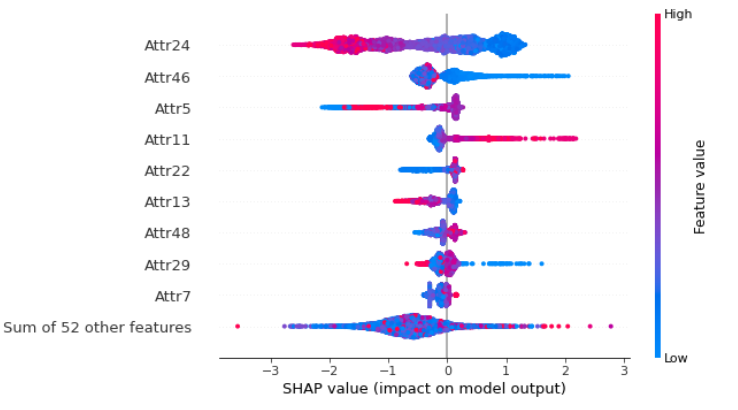

In [ ]:
shap.initjs()
shap.plots.waterfall(shap_values[0])

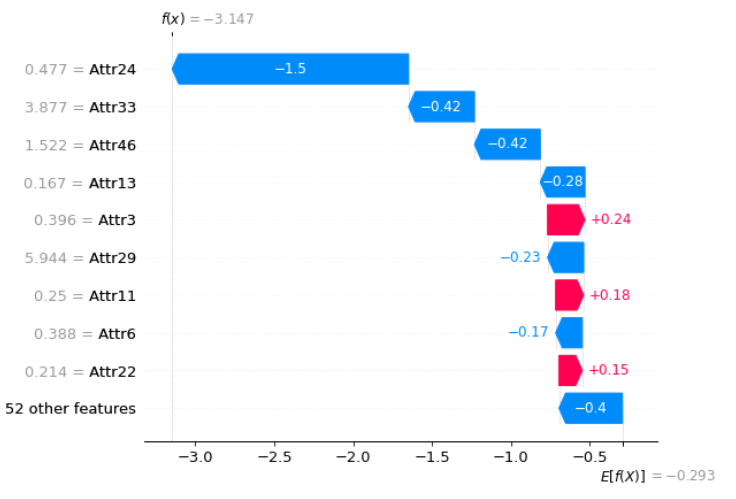

#**iBreakDown (iBD)**

In [10]:
model_xgb_exp = dx.Explainer(model_xgb, X, y, label = "df RF Pipeline")

Preparation of a new explainer is initiated

  -> data              : 7027 rows 61 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 7027 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : df RF Pipeline
  -> predict function  : <function yhat_proba_default at 0x7f2b15ec8a70> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.000675, mean = 0.203, max = 0.988
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.819, mean = -0.165, max = 0.946
  -> model_info        : package xgboost

A new explainer has been created!


In [ ]:
model_xgb_exp.model_parts().plot()

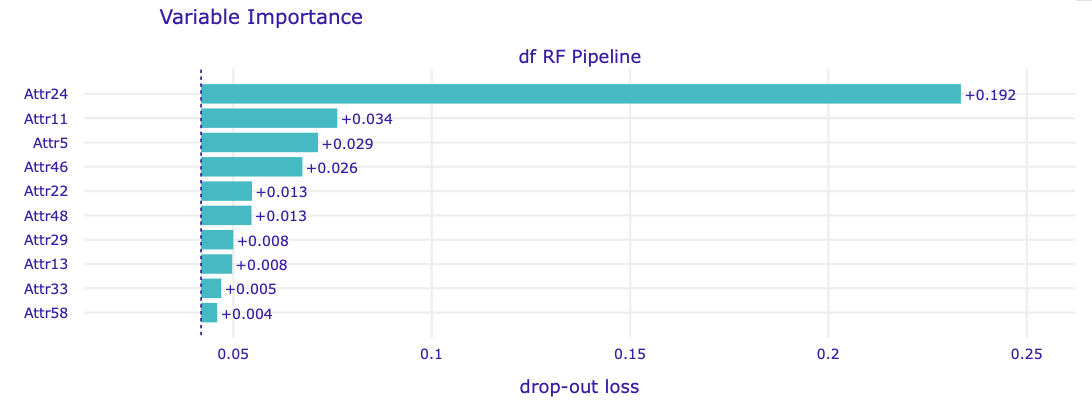

In [ ]:
no_interactions = model_xgb_exp.predict_parts(X.iloc[0], 
                type = 'break_down',
                label = "BreakDown plot with no interactions for company X",
                )
no_interactions.result
no_interactions.plot()

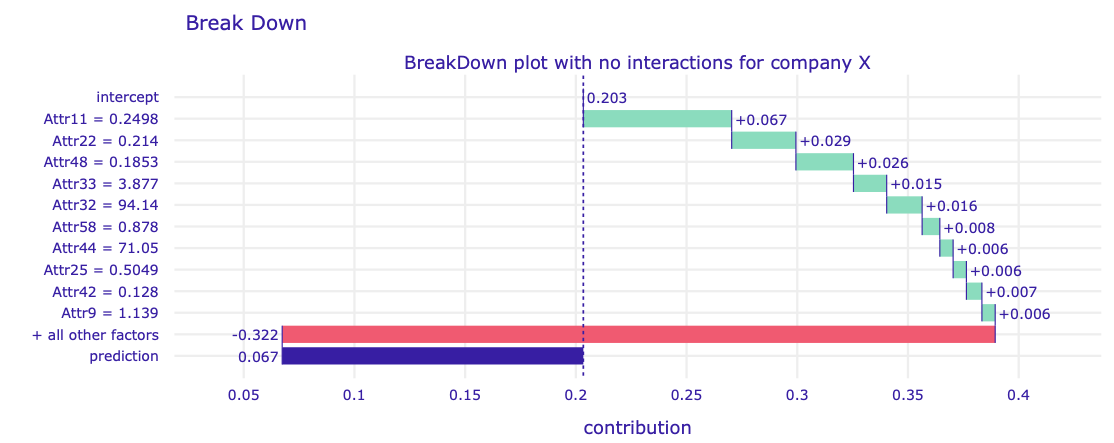

In [ ]:
interactions = model_xgb_exp.predict_parts(X.iloc[0], 
                type = 'break_down_interactions',
                label = "iBreakDown plot with interactions for company X",
                interaction_preference = 3
                )
# interactions.result
interactions.plot()

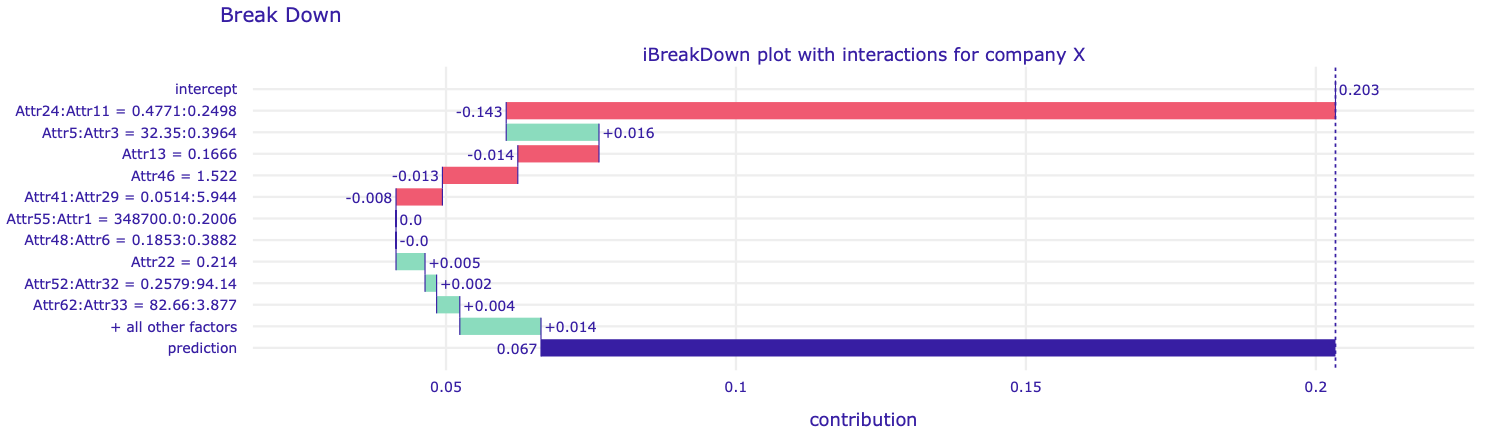

#**Partial Dependence Plots (PDP)**

Data used for Attr24 column is 99.76872442625867%
Data used for Attr11 column is 99.71535314001068%
Data used for Attr46 column is 98.59455612880271%
Data used for Attr5 column is 99.73314356876001%


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


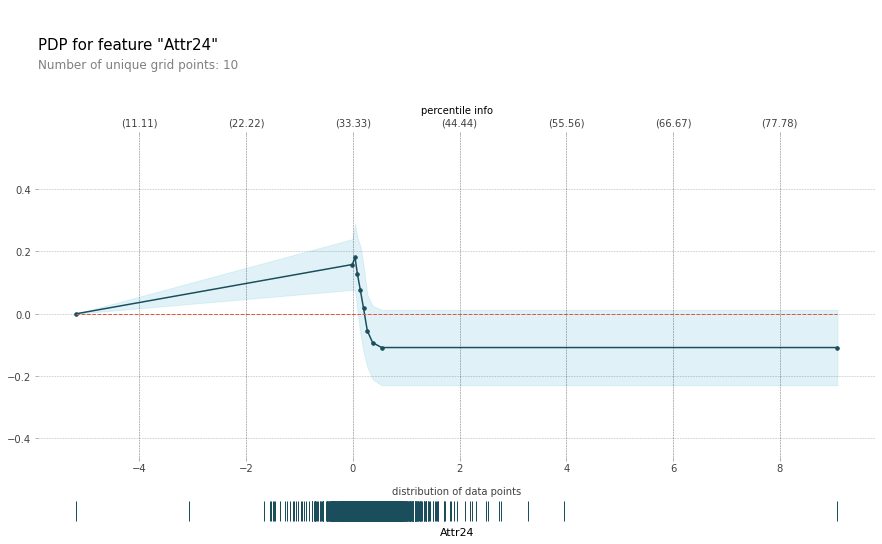

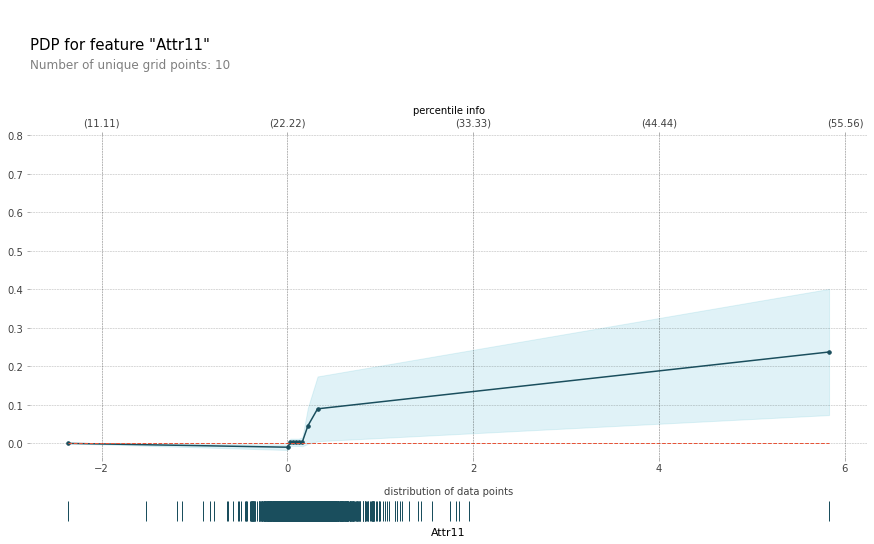

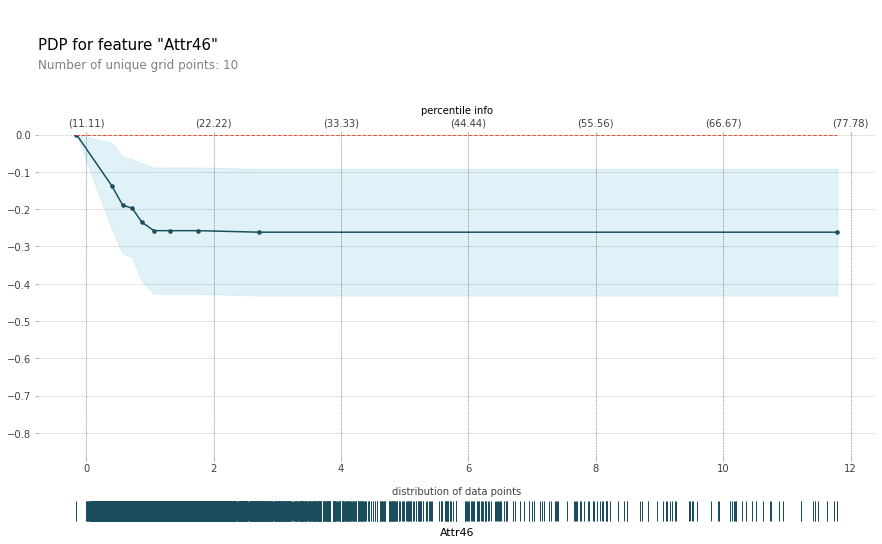

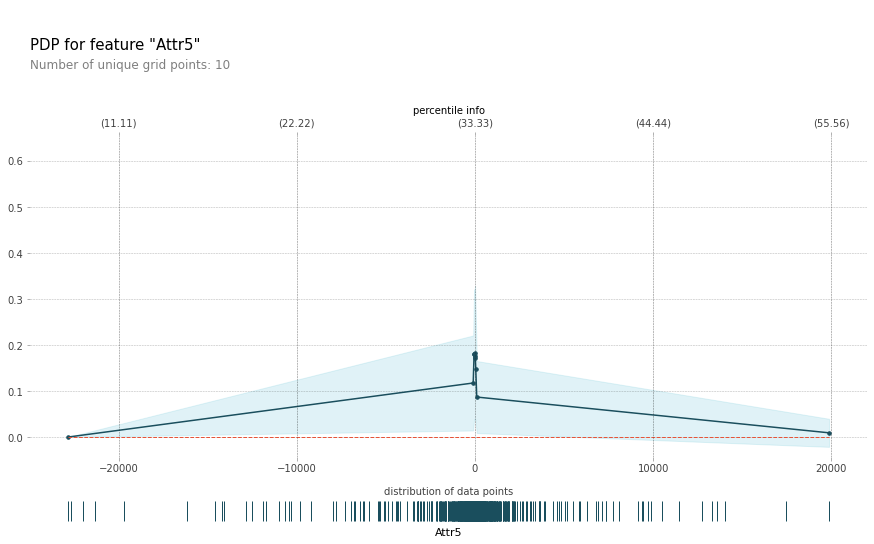

In [14]:
lst = [ 'Attr24', 'Attr11', 'Attr46', 'Attr5']
for feature in lst:
  feature = feature

  #calculate z-score of each to remove outliers --> ensure all 10 points of PDP plot are spread out and not clustered together
  z_score = np.abs(stats.zscore(X_train[feature]))
  filtered_entries = (z_score < 0.7)
  new_X = X_train[filtered_entries]
  print(f"Data used for {feature} column is {new_X.shape[0]/5621 * 100}%")

  isolated = pdp_isolate(
      model=model_xgb, 
      dataset=new_X, 
      model_features=new_X.columns, 
      feature=feature
  )

  pdp_plot(isolated, feature_name=feature, plot_lines=False, center=True, frac_to_plot=0.9, plot_pts_dist=True,x_quantile=False, show_percentile=True, cluster = False, n_cluster_centers = 10)